# Manipulating kernels


GPflow comes with a range of kernels that can be combined to make new kernels. In this notebook, we examine some of the kernels, show how kernels can be combined, and discuss the active_dims feature.

In [11]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import tensorflow as tf
%matplotlib inline

## First example

Here is how to create a Matern 3/2 covariance kernel. The lengthscale and the variance are optional parameters and they both have `1.0` as default value.

In [13]:
k = gpflow.kernels.Matern32(variance=10., lengthscale=2)

We can get information about the kernel using `print_summary(k)` (plain text). The option `fmt="notebook"` is also available to obtain a nicer rendering when working in a notebook.

In [14]:
from gpflow.utilities import print_summary
print_summary(k, fmt="notebook")

name,class,transform,trainable,shape,dtype,value
Matern32.variance,Parameter,Softplus,True,(),float64,10
Matern32.lengthscale,Parameter,Softplus,True,(),float64,2


The parameter values can be accessed and assigned new values with the same syntax as for models:

In [15]:
print(k.lengthscale)
k.lengthscale.assign(.5)
print(k.lengthscale)

<tf.Tensor: id=1515, shape=(), dtype=float64, numpy=2.0>
<tf.Tensor: id=1535, shape=(), dtype=float64, numpy=0.5>


Finally, we can compute covariance matrices by calling directly the kernel object:

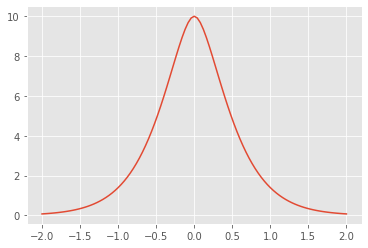

In [16]:
X1 = np.array([[0.]])
X2 = np.linspace(-2, 2, 101).reshape(-1, 1)

K21 = k(X2, X1)   # cov(f(X2), f(X1)), matrix with shape [101, 1]
K22 = k(X2)       # equivalent to k(X2, X2): matrix with shape [101, 101], 

# plotting
plt.figure()
plt.plot(X2, K21)

## Implemented Kernels

GPflow comes with lots of standard kernels. There are a couple of very simple kernels which produce constant functions, linear functions and white noise functions:

 * gpflow.kernels.Constant

 * gpflow.kernels.Linear

 * gpflow.kernels.White

And some stationary functions which produce samples with varying degrees of smoothness:

 * gpflow.kernels.Exponential and gpflow.kernels.Matern12

 * gpflow.kernels.Matern32

 * gpflow.kernels.Matern52

 * gpflow.kernels.SquaredExponential

 * gpflow.kernels.RationalQuadratic

And two kernels which produce periodic samples:

 * gpflow.kernels.Cosine

 * gpflow.kernels.Periodic
 
Other kernels that are implemented in core GPflow:
    
 * gpflow.kernels.Polynomial

 * gpflow.kernels.ArcCosine ("neural network kernel")

 * gpflow.kernels.Coregion
 
Let's define some plotting utils functions and have a look at samples from the prior for some of them:

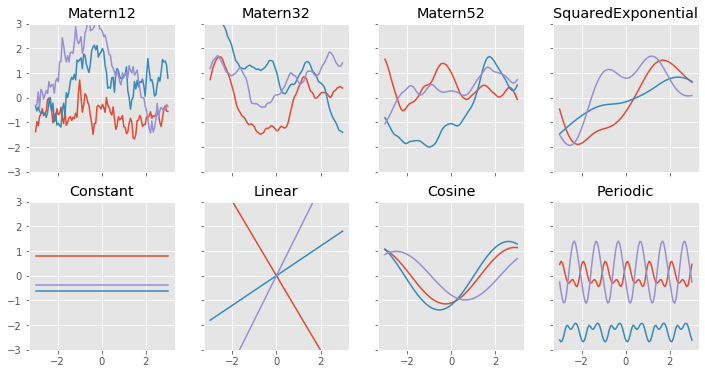

In [17]:
def plotkernelsample(k, ax, xmin=-3, xmax=3):
    xx = np.linspace(xmin, xmax, 100)[:,None]
    K = k(xx)
    ax.plot(xx, np.random.multivariate_normal(np.zeros(100), K, 3).T)
    ax.set_title(k.__class__.__name__)
    
np.random.seed(27)
f, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
plotkernelsample(gpflow.kernels.Matern12(), axes[0,0])
plotkernelsample(gpflow.kernels.Matern32(), axes[0,1])
plotkernelsample(gpflow.kernels.Matern52(), axes[0,2])
plotkernelsample(gpflow.kernels.RBF(), axes[0,3])
plotkernelsample(gpflow.kernels.Constant(), axes[1,0])
plotkernelsample(gpflow.kernels.Linear(), axes[1,1])
plotkernelsample(gpflow.kernels.Cosine(), axes[1,2])
plotkernelsample(gpflow.kernels.Periodic(), axes[1,3])
axes[0,0].set_ylim(-3, 3);

## Combining kernels
Valid kernels can be made by adding and multiplying kernels. To do this in GPflow, you can add or multiply intances of kernels, which creates a new kernel with the parameters of the old ones. 

name,class,transform,trainable,shape,dtype,value
Sum.Sum_kernels[0].variance,Parameter,Softplus,True,(),float64,1
Sum.Sum_kernels[0].lengthscale,Parameter,Softplus,True,(),float64,1
Sum.Sum_kernels[1].variance,Parameter,Softplus,True,(),float64,1


name,class,transform,trainable,shape,dtype,value
Product.Product_kernels[0].variance,Parameter,Softplus,True,(),float64,1
Product.Product_kernels[0].lengthscale,Parameter,Softplus,True,(),float64,1
Product.Product_kernels[1].variance,Parameter,Softplus,True,(),float64,1


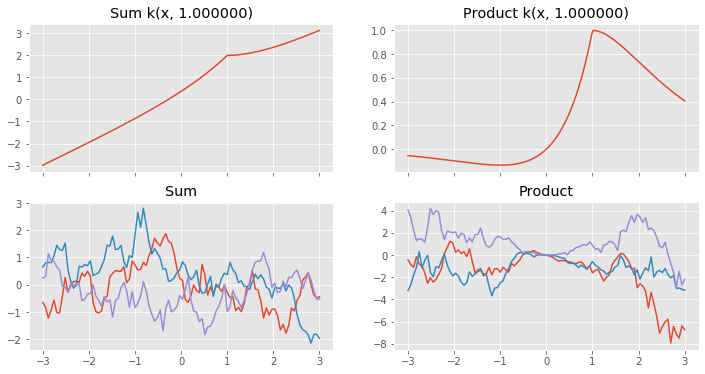

In [20]:
k1 = gpflow.kernels.Matern12()
k2 = gpflow.kernels.Linear()

k3 = k1 + k2
k4 = k1 * k2

print_summary(k3, fmt="notebook")
print_summary(k4, fmt="notebook")

def plotkernelfunction(k, ax, xmin=-3, xmax=3, other=0):
    xx = np.linspace(xmin, xmax, 200)[:,None]
    ax.plot(xx, k(xx, np.zeros((1,1)) + other))
    ax.set_title(k.__class__.__name__ + ' k(x, %f)'%other)

f, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
plotkernelfunction(k3, axes[0, 0], other=1.)
plotkernelfunction(k4, axes[0, 1], other=1.)
plotkernelsample(k3, axes[1, 0])
plotkernelsample(k4, axes[1, 1])

## Kernels for higher dimensional input spaces

When the input space is more than one-dimensional, it is possible to assign one lengthscale parameter per input:

In [21]:
k = gpflow.kernels.Matern52(lengthscale=[.1, .2, 2.])
print_summary(k, fmt="notebook")

name,class,transform,trainable,shape,dtype,value
Matern52.variance,Parameter,Softplus,True,(),float64,1.0
Matern52.lengthscale,Parameter,Softplus,True,"(3,)",float64,[0.1 0.2 2. ]


## Active dimensions

When combining kernels, it's often helpful to have bits of the kernel working on different dimensions. For example, to model a function that is linear in the first dimension and smooth in the second, we could use a combination of Linear and Matern52 kernels, one for each dimension.

To tell GPflow which dimension a kernel applies to, one specifies the active_dims, which is a list of integers. Note that the `input_dim` of the kernel corresponds to the length of the `active_dims` vector. This can be very helpful for creating addivive models:


In [22]:
k1 = gpflow.kernels.Matern52(active_dims=[0], lengthscale=.2)
k2 = gpflow.kernels.Matern52(active_dims=[1], lengthscale=.2)
k = k1 + k2

Let's plot this kernel and a sample from it:

Text(0.5, 1.0, 'GP sample 2')

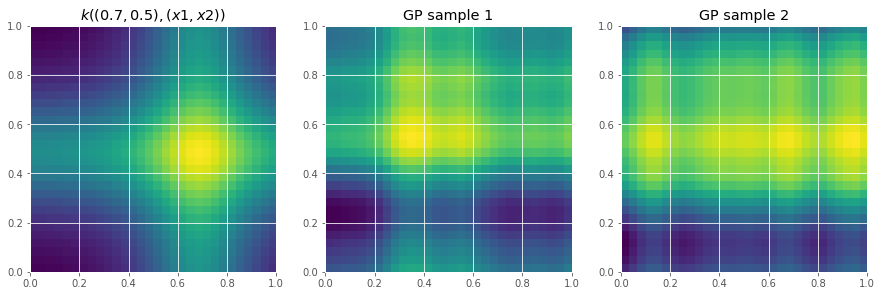

In [23]:
n_grid = 30
x = np.linspace(0, 1, n_grid)
X, Y = np.meshgrid(x, x)
X = np.vstack((X.flatten(), Y.flatten())).T

# plot the kernel
KxX = k(X, X[470:471, :]).numpy().reshape(n_grid, n_grid)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(KxX, extent=[0,1,0,1])
axes[0].set_title(f'$k((0.7, 0.5), (x1, x2))$')

# plot a gp sample
K = k(X).numpy()
Z = np.random.multivariate_normal(np.zeros(n_grid**2), K, 2)
axes[1].imshow(Z[0, :].reshape(n_grid, n_grid), extent=[0,1,0,1])
axes[1].set_title('GP sample 1')
axes[2].imshow(Z[1, :].reshape(n_grid, n_grid), extent=[0,1,0,1])
axes[2].set_title('GP sample 2')

## See also

GPflow makes it easy to define new covariance functions. This is covered in the notebook [kernel design](../tailor/kernel_design.ipynb).